<a href="https://colab.research.google.com/github/ShallyBansal963/Credit_Card_Transaction_Dashboard/blob/main/faster_rcnn_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import VOCDetection
import numpy as np



transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])


train_dataset = torchvision.datasets.VOCDetection(
    root='/content/VOCdevkit',
    year='2007',
    image_set='trainval',
    download=True,
    transform=transform
)

subset_indices = list(range(100))
train_dataset_subset = Subset(train_dataset, subset_indices)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset_subset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT')
model.to(device)
model.train()

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 10
for epoch in range(num_epochs):
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        new_targets = []

        for target in targets:
            boxes = []
            labels = []
            for obj in target['annotation']['object']:
                bndbox = obj['bndbox']
                boxes.append([
                    float(bndbox['xmin']),
                    float(bndbox['ymin']),
                    float(bndbox['xmax']),
                    float(bndbox['ymax'])
                ])

                labels.append(1)
            new_target = {
                'boxes': torch.tensor(boxes, dtype=torch.float32).to(device),
                'labels': torch.tensor(labels, dtype=torch.int64).to(device),
            }
            new_targets.append(new_target)
        loss_dict = model(images, new_targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1} Loss: {losses.item()}")
print("Training complete.")
# Save the model

torch.save(model.state_dict(), 'faster_rcnn_voc.pth')


100%|██████████| 460032000/460032000 [00:33<00:00, 13916288.74it/s]


Extracting /content/VOCdevkit/VOCtrainval_06-Nov-2007.tar to /content/VOCdevkit


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 142MB/s]


Epoch 1 Loss: 5.5167365074157715
Epoch 2 Loss: 0.4468226432800293
Epoch 3 Loss: 8.452659606933594
Epoch 4 Loss: 7.168576240539551
Epoch 5 Loss: 10.07454776763916
Epoch 6 Loss: 0.12608465552330017
Epoch 7 Loss: 0.4945825934410095
Epoch 8 Loss: 0.593970537185669
Epoch 9 Loss: 5.875885963439941
Epoch 10 Loss: 0.2424595057964325
Training complete.


100%|██████████| 451020800/451020800 [00:33<00:00, 13581507.96it/s]


Extracting /content/VOCdevkit/VOCtest_06-Nov-2007.tar to /content/VOCdevkit


AttributeError: 'Image' object has no attribute 'to'

In [ ]:
# Save the model
torch.save(model.state_dict(), 'faster_rcnn_voc.pth')


In [ ]:
from PIL import Image
import torch
import torchvision.transforms as T

# Define the transformation to convert PIL Image to tensor
transform = T.Compose([
    T.ToTensor(),  # Convert PIL image to tensor
])

def detect_objects(image_path):
    # Load the image
    image = Image.open(image_path).convert("RGB")

    # Apply the transformation to the image
    image_tensor = transform(image).unsqueeze(0).to(device)  # Convert to tensor and add batch dimension

    # Inference
    with torch.no_grad():
        predictions = model(image_tensor)

    return predictions

# Example usage
image_path = "/content/VOCdevkit/VOCdevkit/VOC2007/JPEGImages/000001.jpg"
detections = detect_objects(image_path)

print(detections)  # Display the detections


[{'boxes': tensor([[  1.0116, 256.3896, 353.0000, 500.0000],
        [  2.7046, 216.3855, 164.6330, 500.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0620, 0.0577], device='cuda:0')}]


In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import VOCDetection
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Custom collate function to handle batches of different sizes
def collate_fn(batch):
    return tuple(zip(*batch))

# Define a custom dataset to extract 'boxes' and 'labels' from the VOC dataset
class VOCDetectionCustom(VOCDetection):
    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)

        # Extract boxes and labels
        boxes = []
        labels = []

        for obj in target['annotation']['object']:
            # Get bounding box
            bndbox = obj['bndbox']
            xmin = float(bndbox['xmin'])
            ymin = float(bndbox['ymin'])
            xmax = float(bndbox['xmax'])
            ymax = float(bndbox['ymax'])
            boxes.append([xmin, ymin, xmax, ymax])

            # Get the label
            label = obj['name']  # This will be a string; you might need to convert it to an integer ID
            labels.append(1)  # Assuming '1' is the class label for the object (you can customize this)

        # Convert lists to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Create a target dictionary
        target = {
            'boxes': boxes,
            'labels': labels
        }

        return img, target

# Load and preprocess the dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((300, 300)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = VOCDetectionCustom(root='/content/VOCdevkit', year='2007', image_set='trainval', download=True, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


def collate_fn(batch):
    return tuple(zip(*batch))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

# Load the pre-trained Faster R-CNN model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = fasterrcnn_resnet50_fpn(weights='COCO_V1')  # Updated for newer version of torchvision
model.to(device)


optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
# Model Training
model.train()
for epoch in range(10):
    for images, targets in train_loader:
        images = [image.to(device) for image in images]
        # Move only the tensors in targets (like 'boxes' and 'labels') to the device
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}: Loss = {losses.item()}")

print("Training complete.")
torch.save(model.state_dict(), 'faster_rcnn_voc.pth')



Using downloaded and verified file: /content/VOCdevkit/VOCtrainval_06-Nov-2007.tar
Extracting /content/VOCdevkit/VOCtrainval_06-Nov-2007.tar to /content/VOCdevkit
Epoch 1: Loss = 0.23851674795150757
Epoch 2: Loss = 2.3515212535858154
Epoch 3: Loss = 0.24922946095466614
Epoch 4: Loss = 0.30642077326774597
Epoch 5: Loss = 3.212217092514038
Epoch 6: Loss = 3.398390769958496
Epoch 7: Loss = 2.137032985687256
Epoch 8: Loss = 0.342088520526886
Epoch 9: Loss = 0.21340897679328918
Epoch 10: Loss = 0.29341086745262146
Training complete.


In [10]:
# Save the trained model's state_dict
torch.save(model.state_dict(), 'faster_rcnn_voc2.pth')


Mean Precision: 0.5137
Mean Recall: 0.2787


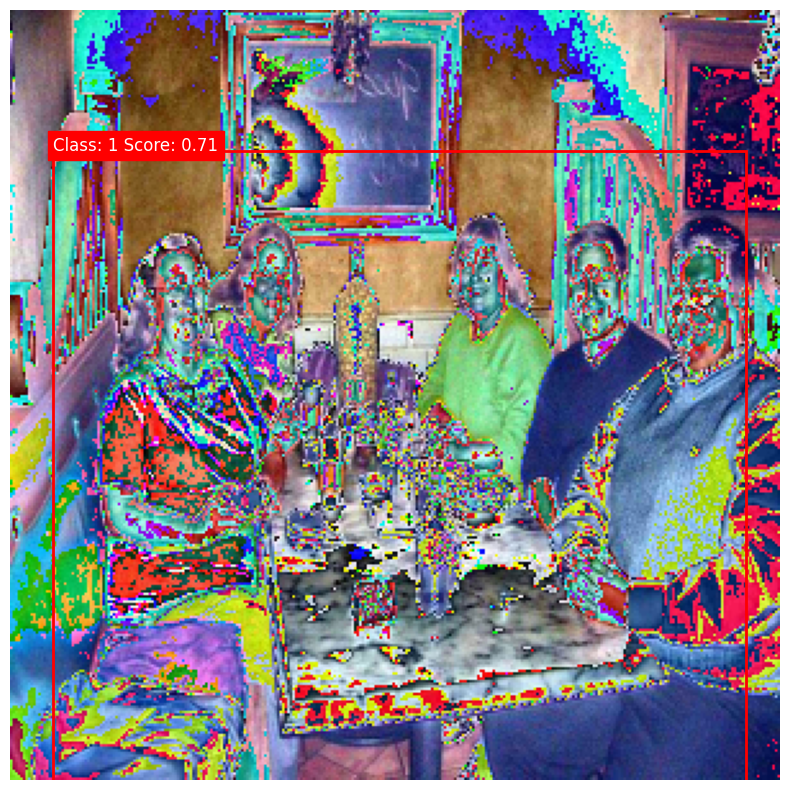

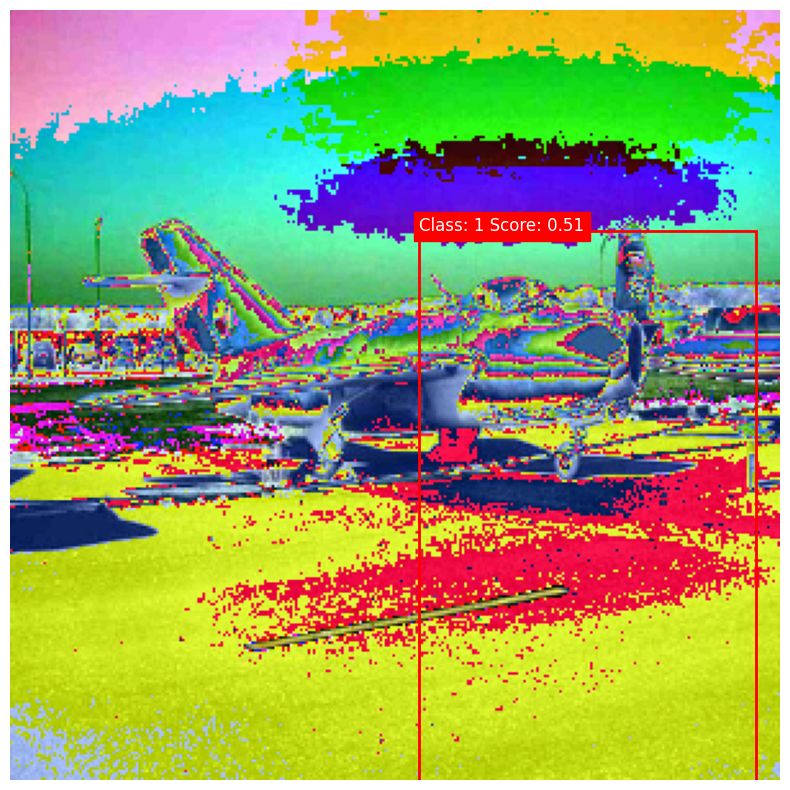

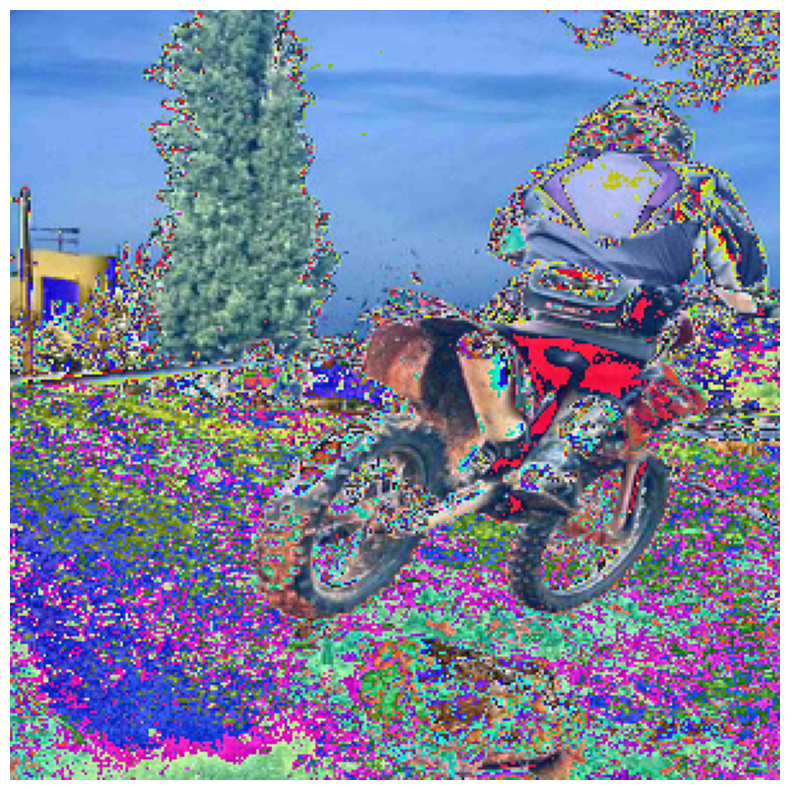

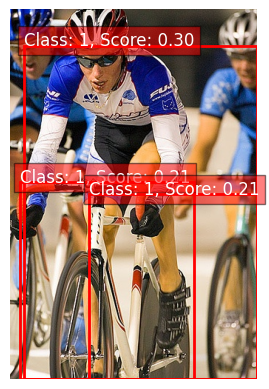

In [19]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt

# Load the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = fasterrcnn_resnet50_fpn(weights=None)
model.load_state_dict(torch.load('faster_rcnn_voc.pth'))
model.to(device)
model.eval()
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image)
    image_tensor = image_tensor.unsqueeze(0)
    return image_tensor

image_path = '/content/VOCdevkit/VOCdevkit/VOC2007/JPEGImages/000023.jpg'
image_tensor = load_image(image_path).to(device)

with torch.no_grad():
    predictions = model(image_tensor)

score_threshold = 0.5
boxes = predictions[0]['boxes'][predictions[0]['scores'] > score_threshold].cpu().numpy()
labels = predictions[0]['labels'][predictions[0]['scores'] > score_threshold].cpu().numpy()
scores = predictions[0]['scores'][predictions[0]['scores'] > score_threshold].cpu().numpy()

def plot_image_with_boxes(image_path, boxes, labels, scores):
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)

    ax = plt.gca()
    for box, label, score in zip(boxes, labels, scores):
        xmin, ymin, xmax, ymax = box
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red', linewidth=2))
        ax.text(xmin, ymin, f'Class: {label}, Score: {score:.2f}', fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

plot_image_with_boxes(image_path, boxes, labels, scores)


In [21]:
import torch
from torchvision.ops import box_iou

def evaluate_per_class(model, data_loader, device):
    # Set the model to evaluation mode
    model.eval()

    # Initialize dictionaries to store true positives, false positives, and false negatives
    tp_per_class = {}
    fp_per_class = {}
    fn_per_class = {}

    # Iterate through the data loader
    with torch.no_grad():
        for images, targets in data_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Get predictions from the model
            predictions = model(images)

            for target, prediction in zip(targets, predictions):
                target_boxes = target['boxes']
                target_labels = target['labels']
                pred_boxes = prediction['boxes']
                pred_scores = prediction['scores']
                pred_labels = prediction['labels']

                num_classes = 21

                # Initialize counters for each class
                for label in range(1, num_classes):  # Assuming class labels start from 1
                    if label not in tp_per_class:
                        tp_per_class[label] = 0
                        fp_per_class[label] = 0
                        fn_per_class[label] = 0

                # Calculate IoU
                if len(pred_boxes) > 0 and len(target_boxes) > 0:
                    iou = box_iou(pred_boxes, target_boxes)

                    # Determine matches based on IoU threshold (e.g., 0.5)
                    for pred_idx, pred_box in enumerate(pred_boxes):
                        matched = False
                        for target_idx, target_box in enumerate(target_boxes):
                            if iou[pred_idx, target_idx] > 0.5:  # IoU threshold
                                matched = True
                                tp_per_class[target_labels[target_idx].item()] += 1
                                break
                        if not matched:
                            fp_per_class[pred_labels[pred_idx].item()] += 1

                    # Count false negatives
                    for target_idx in range(len(target_boxes)):
                        if target_labels[target_idx].item() not in pred_labels:
                            fn_per_class[target_labels[target_idx].item()] += 1
                else:
                    # All predictions are false positives if no targets
                    for pred_label in pred_labels:
                        fp_per_class[pred_label.item()] += 1

                    # All targets are false negatives if no predictions
                    for target_label in target_labels:
                        fn_per_class[target_label.item()] += 1

    # Calculate precision and recall for each class
    precision_per_class = {}
    recall_per_class = {}
    for label in range(1, num_classes):  # Assuming class labels start from 1
        tp = tp_per_class.get(label, 0)
        fp = fp_per_class.get(label, 0)
        fn = fn_per_class.get(label, 0)

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        precision_per_class[label] = precision
        recall_per_class[label] = recall

    return precision_per_class, recall_per_class

# Example usage
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
precision, recall = evaluate_per_class(model, test_loader, device)

# Print precision and recall for each class
for class_id in precision.keys():
    print(f"Class {class_id} - Precision: {precision[class_id]:.4f}, Recall: {recall[class_id]:.4f}")


Class 1 - Precision: 0.0731, Recall: 0.9990
Class 2 - Precision: 0.0000, Recall: 0.0000
Class 3 - Precision: 0.0000, Recall: 0.0000
Class 4 - Precision: 0.0000, Recall: 0.0000
Class 5 - Precision: 0.0000, Recall: 0.0000
Class 6 - Precision: 0.0000, Recall: 0.0000
Class 7 - Precision: 0.0000, Recall: 0.0000
Class 8 - Precision: 0.0000, Recall: 0.0000
Class 9 - Precision: 0.0000, Recall: 0.0000
Class 10 - Precision: 0.0000, Recall: 0.0000
Class 11 - Precision: 0.0000, Recall: 0.0000
Class 12 - Precision: 0.0000, Recall: 0.0000
Class 13 - Precision: 0.0000, Recall: 0.0000
Class 14 - Precision: 0.0000, Recall: 0.0000
Class 15 - Precision: 0.0000, Recall: 0.0000
Class 16 - Precision: 0.0000, Recall: 0.0000
Class 17 - Precision: 0.0000, Recall: 0.0000
Class 18 - Precision: 0.0000, Recall: 0.0000
Class 19 - Precision: 0.0000, Recall: 0.0000
Class 20 - Precision: 0.0000, Recall: 0.0000


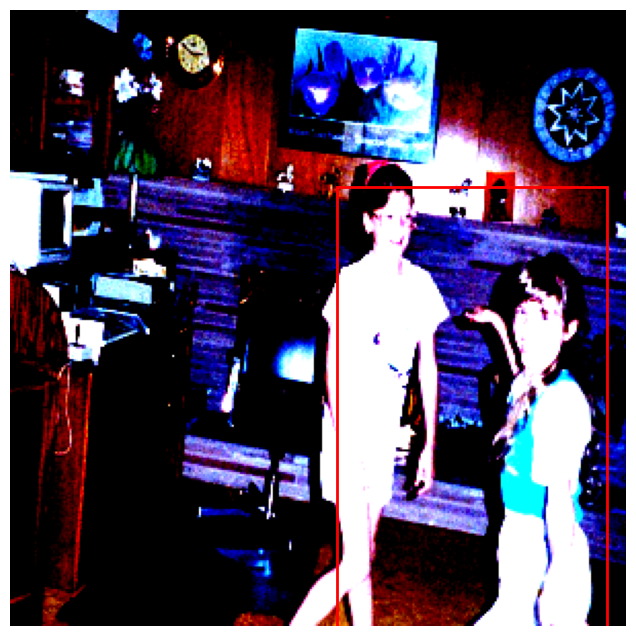

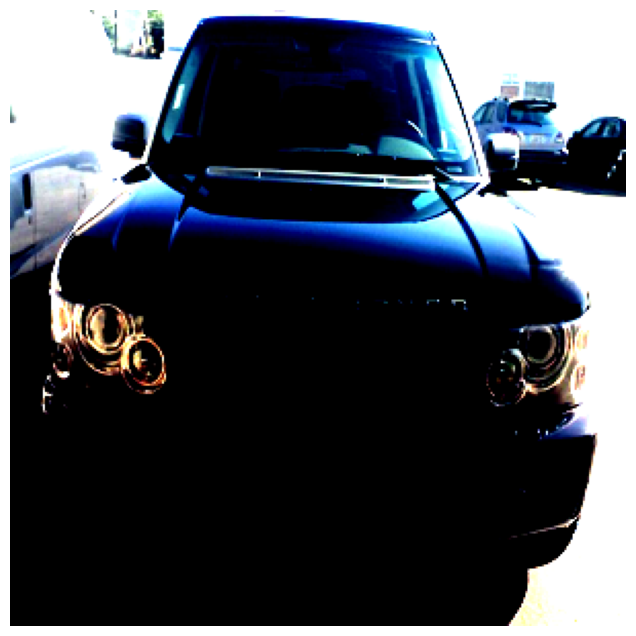

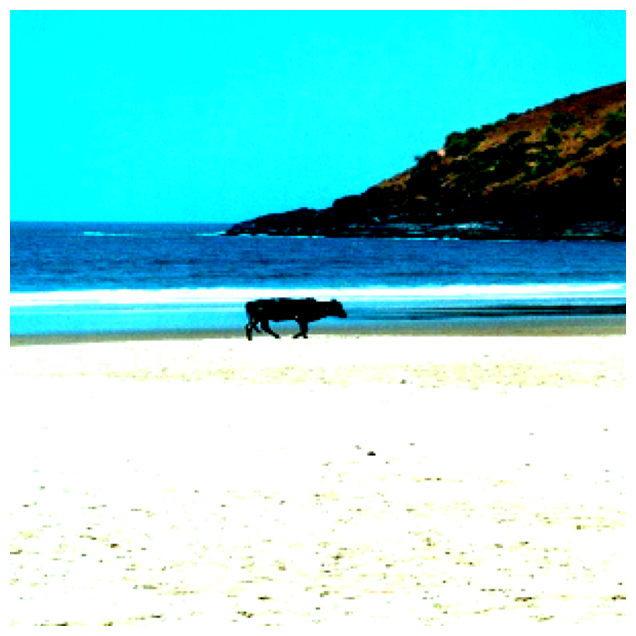

In [22]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

def visualize_predictions(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        for images, targets in data_loader:
            images = [image.to(device) for image in images]
            predictions = model(images)

            # Visualize a few predictions
            for i in range(len(images)):
                plt.figure(figsize=(8, 8))
                plt.imshow(images[i].cpu().permute(1, 2, 0))
                plt.axis('off')

                # Draw predicted boxes
                pred_boxes = predictions[i]['boxes'].cpu().numpy()
                pred_scores = predictions[i]['scores'].cpu().numpy()

                for j, box in enumerate(pred_boxes):
                    if pred_scores[j] > 0.5:  # Adjust threshold as needed
                        plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                                            edgecolor='red', facecolor='none', lw=2))

                plt.show()
            break  # Just visualize for one batch

# Example usage
visualize_predictions(model, test_loader, device)
